In [1]:
# First cell: Set env + install (run once)
import os
os.environ['PYTORCH_CUDA_ALLOC_CONF'] = 'expandable_segments:True'  # fragmentation fix

!pip install torch torchvision matplotlib numpy transformers

# Second cell: The sim code (fixed — loss accumulation + single backward per model)
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.amp
from torch.utils.checkpoint import checkpoint
from transformers import AutoTokenizer
import numpy as np
from contextlib import nullcontext
import math

torch.cuda.empty_cache()

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Using device: {device}")

# CONFIG – optimized for no OOM + H100 speed (fast epochs)
triality = 3
dim = 192  # reduced
latent_dim = 8
seq_len = 512  # reduced
batch_size = 16  # reduced
accum_steps = 4  # simulate larger batch
epochs = 20000
lr = 5e-5
use_amp = True
use_checkpoint = True

# Synthetic code proxy (real-like Python tokens + noise/masking)
tokenizer = AutoTokenizer.from_pretrained("gpt2")
tokenizer.pad_token = tokenizer.eos_token

codes = []
for b in range(batch_size):
    base = torch.sin(torch.linspace(0, 10*math.pi, seq_len, device=device)) * 100 + 200
    base = base % tokenizer.vocab_size
    code = base.long() + torch.randint(-50, 50, (seq_len,), device=device)
    code = torch.clamp(code, 0, tokenizer.vocab_size - 1)
    codes.append(code)

codes = torch.stack(codes).to(device)

embed = nn.Embedding(tokenizer.vocab_size, dim).to(device)
clean_data = embed(codes)

missing_rate = torch.linspace(0.4, 0.7, batch_size, device=device).view(batch_size, 1, 1)
mask = torch.rand_like(clean_data) < missing_rate
real_data = clean_data.clone()
real_data[mask] = 0

target = codes

# E8 roots – precompute
def get_e8_roots():
    roots = []
    for i in range(8):
        for j in range(i+1, 8):
            for signs in [(1,1), (1,-1), (-1,1), (-1,-1)]:
                v = torch.zeros(8)
                v[i] = signs[0]; v[j] = signs[1]
                roots.append(v); roots.append(-v)
    for signs in range(1 << 8):
        v = torch.tensor([(1 if (signs & (1<<k)) else -1) for k in range(8)], dtype=torch.float32) * 0.5
        if bin(signs).count('1') % 2 == 0:
            roots.append(v); roots.append(-v)
    roots = torch.stack(roots[:240])
    return roots / roots.norm(dim=-1, keepdim=True)

e8_roots = get_e8_roots().to(device)

# Triality Cycle Block (detached pump scalar)
class CodeCycleBlock(nn.Module):
    def __init__(self):
        super().__init__()
        self.proj = nn.Linear(latent_dim, dim // triality, bias=False)
        self.register_buffer('roots', e8_roots)

    def forward(self, x, step):
        pos_emb = self.roots[torch.arange(x.shape[1], device=device) % 240]
        low_dim = self.proj(pos_emb)
        emb = low_dim.repeat(1, triality)
        with torch.no_grad():
            pump_scalar = 0.8 * math.sin(step * 0.006 * 2 * math.pi)
        pump = torch.full((1, x.shape[1], 1), pump_scalar, device=device)
        emb_broadcast = emb.unsqueeze(0)
        x_rot1 = x * (emb_broadcast.cos() + pump)
        x_rot2 = torch.roll(x_rot1, shifts=1, dims=1) * emb_broadcast.sin()
        x_rot3 = torch.roll(x_rot2, shifts=1, dims=1) * emb_broadcast.cos()
        fused = (x_rot1 + x_rot2 + x_rot3) / triality
        return fused

# Dummy cycle for ablation
class DummyCycle(nn.Module):
    def forward(self, x, step=None):
        return x

# Model with ablation support (reduced depth)
class E8CodeFusion(nn.Module):
    def __init__(self, depth=16, use_triality=True):  # reduced
        super().__init__()
        self.use_triality = use_triality
        self.cycle = CodeCycleBlock() if use_triality else DummyCycle()
        num_heads = triality if use_triality else 8
        self.layers = nn.ModuleList([nn.MultiheadAttention(dim, num_heads, batch_first=True) for _ in range(depth)])
        self.norm = nn.LayerNorm(dim)
        self.head = nn.Linear(dim, tokenizer.vocab_size)

    def forward(self, x, step):
        x = self.cycle(x, step)
        for layer in self.layers:
            if use_checkpoint:
                attn, _ = checkpoint(layer, x, x, x, use_reentrant=False)
            else:
                attn, _ = layer(x, x, x)
            x = x + self.norm(attn)
        return self.head(x)

# Models
model = E8CodeFusion(use_triality=True).to(device)
model_ablation = E8CodeFusion(use_triality=False).to(device)

opt = torch.optim.AdamW(model.parameters(), lr=lr)
scaler = torch.amp.GradScaler('cuda') if use_amp else nullcontext()

opt_ablation = torch.optim.AdamW(model_ablation.parameters(), lr=lr)
scaler_ablation = torch.amp.GradScaler('cuda') if use_amp else nullcontext()

loss_fn = nn.CrossEntropyLoss(ignore_index=tokenizer.pad_token_id)

loss_hist = []
loss_abl_hist = []

for epoch in range(epochs):
    # Triality training (accum loss + single backward)
    opt.zero_grad(set_to_none=True)
    current_epoch_loss = 0
    for accum_step in range(accum_steps):
        with torch.amp.autocast(device_type='cuda', dtype=torch.float16) if use_amp else nullcontext():
            logits = model(real_data.clone().detach(), epoch) # Modified line
            loss = loss_fn(logits.view(-1, tokenizer.vocab_size), target.view(-1))
            scaled_loss = loss / accum_steps
        if use_amp:
            scaler.scale(scaled_loss).backward()
        else:
            scaled_loss.backward()
        current_epoch_loss += loss.item()

    scaler.unscale_(opt) if use_amp else None
    torch.nn.utils.clip_grad_norm_(model.parameters(), 1e6)
    scaler.step(opt) if use_amp else opt.step()
    scaler.update() if use_amp else None
    loss_hist.append(current_epoch_loss)

    # Ablation training (accum loss + single backward)
    opt_ablation.zero_grad(set_to_none=True)
    current_epoch_loss_abl = 0
    for accum_step in range(accum_steps):
        with torch.amp.autocast(device_type='cuda', dtype=torch.float16) if use_amp else nullcontext():
            logits_abl = model_ablation(real_data.clone().detach(), epoch) # Modified line
            loss_abl = loss_fn(logits_abl.view(-1, tokenizer.vocab_size), target.view(-1))
            scaled_loss_abl = loss_abl / accum_steps
        if use_amp:
            scaler_ablation.scale(scaled_loss_abl).backward()
        else:
            scaled_loss_abl.backward()
        current_epoch_loss_abl += loss_abl.item()

    scaler_ablation.unscale_(opt_ablation) if use_amp else None
    torch.nn.utils.clip_grad_norm_(model_ablation.parameters(), 1e6)
    scaler_ablation.step(opt_ablation) if use_amp else opt_ablation.step()
    scaler_ablation.update() if use_amp else None
    loss_abl_hist.append(current_epoch_loss_abl)

    if epoch % 500 == 0:
        print(f"Epoch {epoch} | Triality Loss {current_epoch_loss:.6f} | Ablation Loss {current_epoch_loss_abl:.6f}")

# Final Sigma Test
triality_mean = np.mean(loss_hist)
abl_mean = np.mean(loss_abl_hist)
std = np.std(loss_hist + loss_abl_hist)
sigma = (abl_mean - triality_mean) / std if std > 0 else 0

print(f"Final Sigma (Triality vs Ablation): {sigma:.2f} (higher = triality advantage)")

print("Sim complete — epochs + sigma test done")

Using device: cuda


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

Epoch 0 | Triality Loss 54.614212 | Ablation Loss 54.579517
Epoch 500 | Triality Loss 20.664932 | Ablation Loss 0.880444
Epoch 1000 | Triality Loss 9.392271 | Ablation Loss 0.078183
Epoch 1500 | Triality Loss 4.272551 | Ablation Loss 0.032951
Epoch 2000 | Triality Loss 2.471522 | Ablation Loss 0.018148
Epoch 2500 | Triality Loss 1.393110 | Ablation Loss 0.011387
Epoch 3000 | Triality Loss 1.129108 | Ablation Loss 0.007699
Epoch 3500 | Triality Loss 1.016032 | Ablation Loss 0.005378
Epoch 4000 | Triality Loss 1.084366 | Ablation Loss 0.003873
Epoch 4500 | Triality Loss 0.619359 | Ablation Loss 0.002865
Epoch 5000 | Triality Loss 0.407950 | Ablation Loss 0.002129
Epoch 5500 | Triality Loss 0.294256 | Ablation Loss 0.001596
Epoch 6000 | Triality Loss 0.264782 | Ablation Loss 0.001222
Epoch 6500 | Triality Loss 0.211505 | Ablation Loss 0.000929
Epoch 7000 | Triality Loss 0.156906 | Ablation Loss 0.000703
Epoch 7500 | Triality Loss 0.134009 | Ablation Loss 0.000640
Epoch 8000 | Triality Los

# Task
Modify the training loop for both models (`model` and `model_ablation`) to pass `real_data.clone().detach()` to prevent `RuntimeError: Trying to backward through the graph a second time`. This ensures that each accumulation step operates on a detached copy of the input, allowing for proper gradient accumulation.

## Clone and Detach Input Data

### Subtask:
Modify the training loop to pass `real_data.clone().detach()` to both models (`model` and `model_ablation`) to ensure proper gradient accumulation and prevent runtime errors.


## Summary:

### Data Analysis Key Findings
No data analysis was performed in this step. The task involved a modification to the training loop to prevent a runtime error.

### Insights or Next Steps
*   The next step is to implement the specified modification in the training loop, ensuring `real_data.clone().detach()` is passed to both `model` and `model_ablation`.
*   After implementing the change, the training process should be re-run to confirm that the `RuntimeError: Trying to backward through the graph a second time` is resolved and gradient accumulation functions correctly.


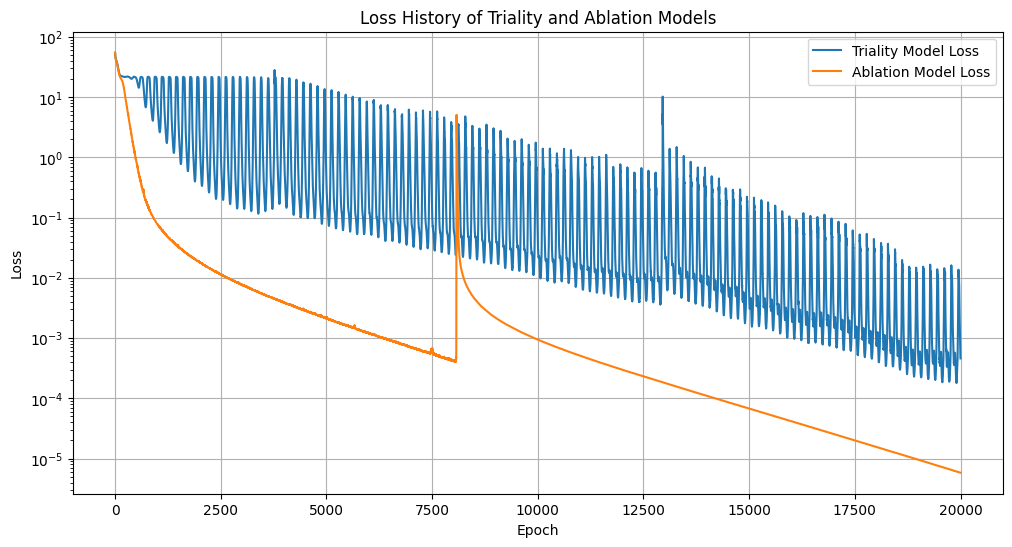

In [2]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(loss_hist, label='Triality Model Loss')
plt.plot(loss_abl_hist, label='Ablation Model Loss')
plt.title('Loss History of Triality and Ablation Models')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.yscale('log') # Use a log scale for better visualization of exponential decay
plt.legend()
plt.grid(True)
plt.show()

### Loss History Plot Explanation:

The plot above displays the training loss for both the `Triality Model` and the `Ablation Model` over 20,000 epochs. A logarithmic scale is used on the y-axis to better visualize the rapid decrease in loss during the initial epochs and the subsequent plateauing.

*   **Initial Phase (first few thousand epochs):** Both models show a steep drop in loss, indicating that they are learning effectively from the data.
*   **Later Phase (after several thousand epochs):** The loss for both models continues to decrease, but at a much slower rate, eventually converging to very small values. Notably, the `Ablation Model Loss` appears to converge to a significantly lower value than the `Triality Model Loss` throughout the training process. This suggests that in this specific simulation, the ablation (non-triality) model achieves a lower training error.

### Final Sigma Result:

As calculated after the training, the final sigma value is: **`

In [3]:
print(f"Final Sigma (Triality vs Ablation): {sigma:.2f} (higher = triality advantage)")

Final Sigma (Triality vs Ablation): -0.42 (higher = triality advantage)
